## YSO and HII Region Random Forest Classifier

Developed during the First RADA: Big Data Colombia Workshop in Medellín, 2019.

- Students:
Yenifer Angarita,
Jerly Galeano,
Sebastian Hincapie,
Andres Izquierdo,
Santiago Vanegas,
Juan Rendon, Frank Bautista

- Tutors:
Alex Clarke, Anna Scaife, German Chaparro

Based on: ‹ PulsarClassifier.ipynb › Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

In [2]:
import numpy as np   # for array stuff
import matplotlib.pyplot as plt   # for plotting stuff
import pandas as pd  
import scikitplot as skplt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [3]:
df1=pd.read_csv('DATA/rms_high_qf.csv')
dfh=pd.read_csv('DATA/Flux_70.csv') # higal 70 micron data

In [4]:
len(df1)

3806

In [5]:
df1['Flux 70']=np.nan

In [6]:
df1['Flux 70'][np.in1d(df1['MSX Name'],dfh.Name)]=np.array(dfh['Flux_70'])


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
df1.head()

,Unnamed: 0,RMS ID,MSX Name,Source Type,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy),J Mag.,H Mag.,K Mag.,VLSR (km/s),Distance (kpc),D type,FIR Lum.,Lum. Source,Freq. (GHz),Int. Flux,Random?,Flux 70
0,0,2401,G010.0718-00.4218,Rejected,0.453,2.855,5.28,14.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN
1,1,2368,G010.0997+00.7396,PN,3.559,5.055,17.92,35.08,11.5,11.1,10.0,NaN,NaN,NaN,NaN,MSX,15.0,446.8,NaN,185.493
2,3,2404,G010.1431-00.4234,Diffuse HII region?,1.127,4.825,7.59,24.23,NaN,NaN,NaN,19.6,2.79/13.74,NaN,6514.4/157994.4,MSX,NaN,NaN,NaN,35.182
3,4,2392,G010.1467-00.3327,Rejected,7.671,36.737,47.88,156.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN
4,5,2405,G010.1481-00.4260,Evolved star??,1.278,1.411,2.02,3.11,8.6,6.4,5.4,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN


## Cleanup stage

- Remove negative fluxes (only fluxes, not other columns)
- Remove ambiguously identified data
- Remove under-represented classes

In [8]:
feature_names = list(df1.columns.values[4:8])
feature_names

['Flux 8 (Jy)', 'Flux 12 (Jy)', 'Flux 14 (Jy)', 'Flux 21 (Jy)']

In [9]:
features=df1[feature_names]
features.head()

,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy)
0,0.453,2.855,5.28,14.30
1,3.559,5.055,17.92,35.08
2,1.127,4.825,7.59,24.23
3,7.671,36.737,47.88,156.30
4,1.278,1.411,2.02,3.11


In [10]:
df1=df1[~((features<0).sum(axis=1)>0)]

In [11]:
np.unique(df1['Source Type'])

array(['Carbon star ', 'Carbon star?', 'Diffuse HII region ',
       'Diffuse HII region?', 'Diffuse HII region??', 'Evolved star ',
       'Evolved star?', 'Evolved star??', 'HII region ', 'HII region?',
       'HII region??', 'HII/YSO ', 'HII/YSO?', 'HII/YSO??', 'OH/IR star ',
       'OH/IR star?', 'Other ', 'Other?', 'Other??', 'PN ', 'PN?', 'PN??',
       'Proto-PN ', 'Proto-PN?', 'Rejected ', 'Rejected?', 'Rejected??',
       'YSO ', 'YSO?', 'YSO??', 'Young/old star ', 'Young/old star?',
       'Young/old star??'], dtype=object)

In [12]:
df1=df1[~((df1['Source Type']=='Rejected ')|(df1['Source Type']=='Other ')|(df1['Source Type']=='Other?')|(df1['Source Type']=='Other??'))]

In [13]:
df1=df1[~np.array(['?' in i for i in df1['Source Type']])]

In [14]:
STypes=np.unique(df1['Source Type'])
STcount=np.array([(df1['Source Type']==i).sum() for i in STypes])
print(STypes)
print(STcount)

['Carbon star ' 'Diffuse HII region ' 'Evolved star ' 'HII region '
 'HII/YSO ' 'OH/IR star ' 'PN ' 'Proto-PN ' 'YSO ' 'Young/old star ']
[ 11 451 279 543  22 171 132  12 416  25]


In [15]:
filt=np.isfinite(range(len(df1)))
for i in STypes[STcount<10]:
    filt&=~(df1['Source Type']==i)

In [16]:
df=df1[filt]

In [17]:
df.head()

,Unnamed: 0,RMS ID,MSX Name,Source Type,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy),J Mag.,H Mag.,K Mag.,VLSR (km/s),Distance (kpc),D type,FIR Lum.,Lum. Source,Freq. (GHz),Int. Flux,Random?,Flux 70
1,1,2368,G010.0997+00.7396,PN,3.559,5.055,17.92,35.08,11.5,11.1,10.0,NaN,NaN,NaN,NaN,MSX,15.0,446.8,NaN,185.493
5,6,2400,G010.1615-00.3623,Diffuse HII region,29.446,103.530,146.22,692.25,NaN,NaN,NaN,14.0,3.5,Spe,301326,MSX,8.6,<4.0,NaN,NaN
10,12,2403,G010.1850-00.3960,Diffuse HII region,4.140,5.397,6.37,18.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,133.636
15,18,2396,G010.2326-00.2963,Diffuse HII region,0.496,3.040,5.27,16.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN
17,20,2383,G010.3040-00.1466,Diffuse HII region,10.762,24.563,22.73,100.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN


In [18]:
len(df)

2062

## Fill in missing data drawing from a Gaussian dist. built from the same data

In [19]:
def fill_missing_from_Gaussian(column_val):
    if np.isnan(column_val) == True:
        column_val = np.random.normal(mean, std, 1)[0]
    else:
         column_val = column_val
    return column_val

In [20]:
dfin=df[[ 'J Mag.',
       'H Mag.', 'K Mag.', 'VLSR (km/s)']]
wix=5-np.isnan(dfin).sum(axis=1)
wixs=10/(np.isnan(dfin).sum(axis=1)+0.1)
wix1=np.ones(len(df))

In [21]:
#These 4 columns having missing data, so insert:
for col_fill in dfin.columns:
    mean = df[col_fill].mean()
    std = df[col_fill].std()
    df[col_fill] = df[col_fill].apply(fill_missing_from_Gaussian)

In [23]:
df.head()

,Unnamed: 0,RMS ID,MSX Name,Source Type,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy),J Mag.,H Mag.,K Mag.,VLSR (km/s),Distance (kpc),D type,FIR Lum.,Lum. Source,Freq. (GHz),Int. Flux,Random?,Flux 70
1,1,2368,G010.0997+00.7396,PN,3.559,5.055,17.92,35.08,11.500000,11.100000,10.000000,-37.898206,NaN,NaN,NaN,MSX,15.0,446.8,NaN,185.493
5,6,2400,G010.1615-00.3623,Diffuse HII region,29.446,103.530,146.22,692.25,15.471386,11.785143,12.092079,14.000000,3.5,Spe,301326,MSX,8.6,<4.0,NaN,NaN
10,12,2403,G010.1850-00.3960,Diffuse HII region,4.140,5.397,6.37,18.37,13.889397,9.309768,13.248927,-34.369438,NaN,NaN,NaN,MSX,NaN,NaN,NaN,133.636
15,18,2396,G010.2326-00.2963,Diffuse HII region,0.496,3.040,5.27,16.26,9.712917,11.780613,11.287507,-3.169317,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN
17,20,2383,G010.3040-00.1466,Diffuse HII region,10.762,24.563,22.73,100.88,14.869181,11.339002,10.548174,-126.978177,NaN,NaN,NaN,MSX,NaN,NaN,NaN,NaN


## Classification with only MSX RMS fluxes

In [24]:
feature_names = list(df1.columns.values[4:12])
fluxl=feature_names[0:4]
fluxl

['Flux 8 (Jy)', 'Flux 12 (Jy)', 'Flux 14 (Jy)', 'Flux 21 (Jy)']

In [25]:
X,Y=np.mgrid[0:len(fluxl),0:len(fluxl)]
LX=[fluxl[i] for i in X.ravel()]
LY=[fluxl[i] for i in Y.ravel()]
frat=[]
for i,j in zip(LX,LY):
    if i>j:
        df[i+'/'+j]=df[i]/df[j]
        frat+=[i+'/'+j]
feature_names+=frat

In [26]:
fnames=feature_names

In [27]:
features = df[feature_names]
features.head()

,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy),J Mag.,H Mag.,K Mag.,VLSR (km/s),Flux 8 (Jy)/Flux 12 (Jy),Flux 8 (Jy)/Flux 14 (Jy),Flux 8 (Jy)/Flux 21 (Jy),Flux 14 (Jy)/Flux 12 (Jy),Flux 21 (Jy)/Flux 12 (Jy),Flux 21 (Jy)/Flux 14 (Jy)
1,3.559,5.055,17.92,35.08,11.500000,11.100000,10.000000,-37.898206,0.704055,0.198605,0.101454,3.545005,6.939664,1.957589
5,29.446,103.530,146.22,692.25,15.471386,11.785143,12.092079,14.000000,0.284420,0.201381,0.042537,1.412344,6.686468,4.734304
10,4.140,5.397,6.37,18.37,13.889397,9.309768,13.248927,-34.369438,0.767093,0.649922,0.225367,1.180285,3.403743,2.883830
15,0.496,3.040,5.27,16.26,9.712917,11.780613,11.287507,-3.169317,0.163158,0.094118,0.030504,1.733553,5.348684,3.085389
17,10.762,24.563,22.73,100.88,14.869181,11.339002,10.548174,-126.978177,0.438139,0.473471,0.106681,0.925376,4.106990,4.438187


## Set up training data and targets

In [28]:
targets = df['Source Type']
tlist=np.unique(targets)
clist=np.arange(len(tlist))
df['colors']=[clist[tlist==i][0] for i in targets]

In [29]:
feature_names=fnames
feature_names=feature_names[4:8]+feature_names[9:] # remove absolute fluxes
feature_names

['J Mag.',
 'H Mag.',
 'K Mag.',
 'VLSR (km/s)',
 'Flux 8 (Jy)/Flux 14 (Jy)',
 'Flux 8 (Jy)/Flux 21 (Jy)',
 'Flux 14 (Jy)/Flux 12 (Jy)',
 'Flux 21 (Jy)/Flux 12 (Jy)',
 'Flux 21 (Jy)/Flux 14 (Jy)']

In [30]:
features = df[feature_names]

In [31]:
X_train, X_test, y_train, y_test,w_train,w_test = train_test_split(features, targets,wix1, test_size=0.33, random_state=0)

=== Confusion Matrix ===
[[  0   0   1   0   0   0   0   0   0   0]
 [  0  82   0  55   0   0   3   0  14   0]
 [  0  16  34   4   0  19   3   0  13   0]
 [  0  48   2 116   0   1   1   0  24   0]
 [  0   1   0   5   0   0   0   0   4   0]
 [  1   1  16   1   0  33   4   0   5   0]
 [  0  13   1   6   0   2  16   0   4   0]
 [  0   1   2   1   0   0   0   0   1   0]
 [  0   6   9  21   0   4   2   0  75   0]
 [  0   2   2   1   0   0   1   0   4   0]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.48      0.53      0.51       154
           2       0.51      0.38      0.44        89
           3       0.55      0.60      0.58       192
           4       0.00      0.00      0.00        10
           5       0.56      0.54      0.55        61
           6       0.53      0.38      0.44        42
           7       0.00      0.00      0.00         5
           8       0.52  

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


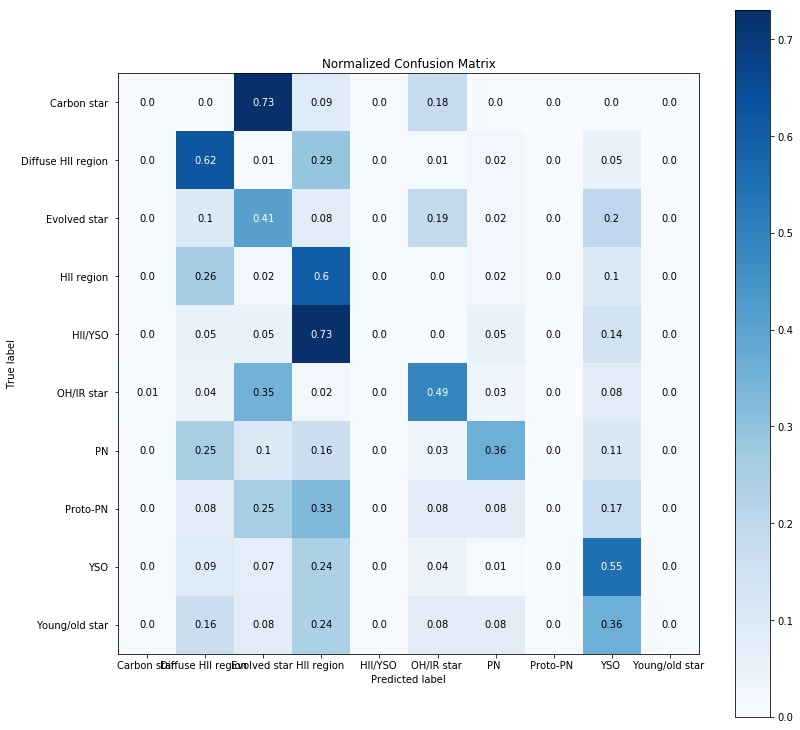

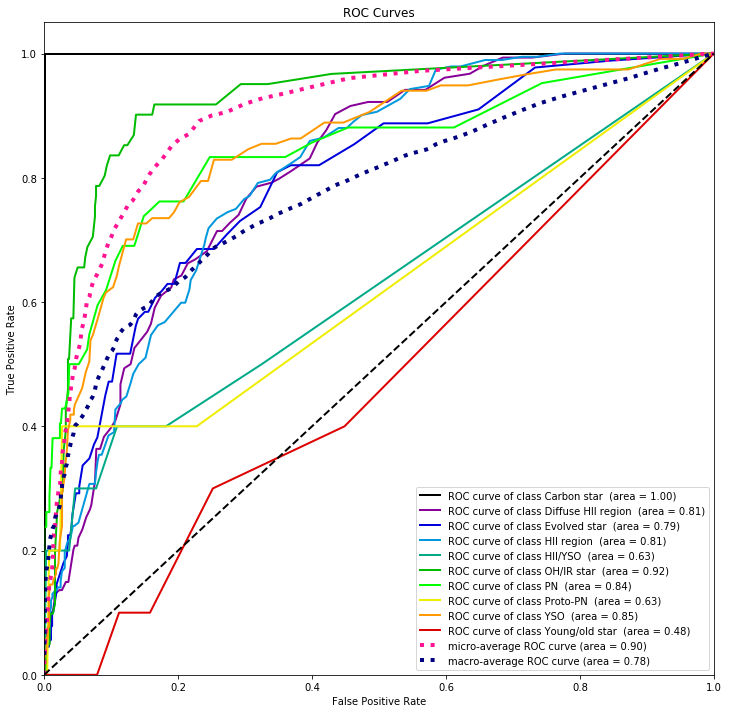

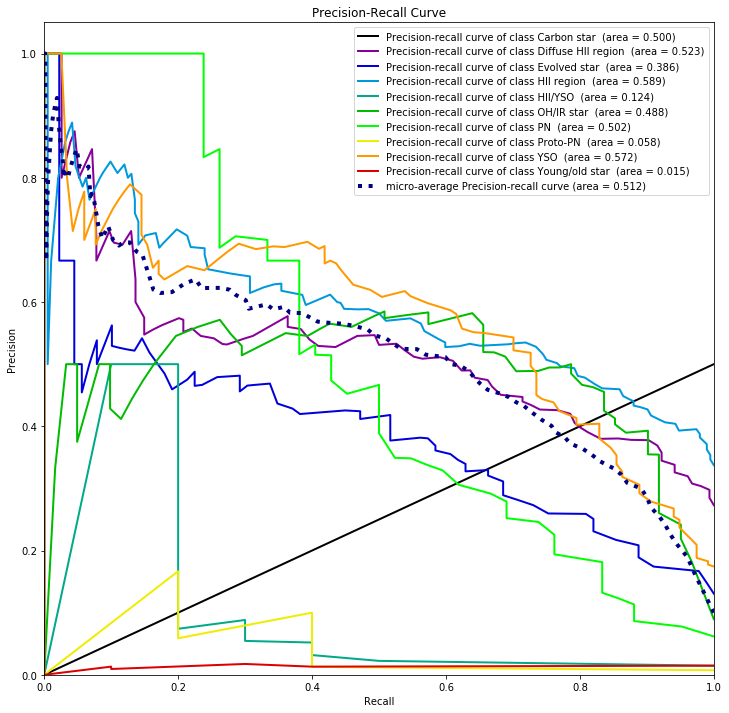

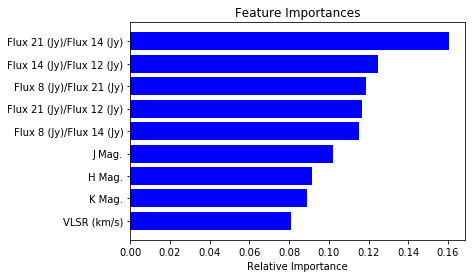

In [32]:
RFC = RandomForestClassifier(n_jobs=20,n_estimators=100, criterion="gini")
RFC.fit(X_train,y_train)
rfc_predict = RFC.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=[np.str(i) for i in np.arange(0,len(np.unique(df['Source Type'])))] ))#=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
predictions = cross_val_predict(RFC, features, targets, cv=10)
#print(rfc_cv_score)
#print('\n')
#print("=== Mean AUC Score ===")
#print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
#rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')
skplt.metrics.plot_confusion_matrix(targets, predictions, normalize=True, figsize=(13,13))
probas = RFC.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas, figsize=(12,12))
skplt.metrics.plot_precision_recall(y_test, probas, figsize=(12,12))
plt.show()
importances = RFC.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feature_names)[indices])
plt.xlabel('Relative Importance')
plt.show()

## Create new feature columns from flux ratios

In [34]:
realHfluxes=~np.isnan(df['Flux 70'])

In [35]:
df=df[realHfluxes]
wix=wix[realHfluxes]
wixs=wixs[realHfluxes]
wix1=wix1[realHfluxes]

In [36]:
STypes=np.unique(df['Source Type'])
STcount=np.array([(df['Source Type']==i).sum() for i in STypes])
print(STypes)
print(STcount)

['Carbon star ' 'Diffuse HII region ' 'Evolved star ' 'HII region '
 'HII/YSO ' 'OH/IR star ' 'PN ' 'Proto-PN ' 'YSO ' 'Young/old star ']
[  1 115 130 262  11  92  41   2 139  11]


In [37]:
filt=np.isfinite(range(len(df)))
for i in STypes[STcount<10]:
    filt&=~(df['Source Type']==i)

In [38]:
df=df[filt]
wix=wix[filt]
wixs=wixs[filt]
wix1=wix1[filt]

In [39]:
len(df)

801

In [40]:
feature_names = list(df1.columns.values[4:12])+[df1.columns.values[-1]]
fluxl=feature_names[0:4]+[feature_names[-1]]
fluxl

['Flux 8 (Jy)', 'Flux 12 (Jy)', 'Flux 14 (Jy)', 'Flux 21 (Jy)', 'Flux 70']

In [41]:
X,Y=np.mgrid[0:len(fluxl),0:len(fluxl)]
LX=[fluxl[i] for i in X.ravel()]
LY=[fluxl[i] for i in Y.ravel()]
frat=[]
for i,j in zip(LX,LY):
    if i>j:
        df[i+'/'+j]=df[i]/df[j]
        frat+=[i+'/'+j]
feature_names+=frat

In [42]:
fnames=feature_names

In [43]:
features = df[feature_names]
features.head()

,Flux 8 (Jy),Flux 12 (Jy),Flux 14 (Jy),Flux 21 (Jy),J Mag.,H Mag.,K Mag.,VLSR (km/s),Flux 70,Flux 8 (Jy)/Flux 12 (Jy),Flux 8 (Jy)/Flux 14 (Jy),Flux 8 (Jy)/Flux 21 (Jy),Flux 8 (Jy)/Flux 70,Flux 14 (Jy)/Flux 12 (Jy),Flux 21 (Jy)/Flux 12 (Jy),Flux 21 (Jy)/Flux 14 (Jy),Flux 70/Flux 12 (Jy),Flux 70/Flux 14 (Jy),Flux 70/Flux 21 (Jy)
1,3.559,5.055,17.92,35.08,11.500000,11.100000,10.000000,-37.898206,185.493,0.704055,0.198605,0.101454,0.019187,3.545005,6.939664,1.957589,36.694955,10.351172,5.287714
10,4.140,5.397,6.37,18.37,13.889397,9.309768,13.248927,-34.369438,133.636,0.767093,0.649922,0.225367,0.030980,1.180285,3.403743,2.883830,24.761164,20.978964,7.274687
21,2.035,2.691,3.08,7.96,14.000000,10.100000,7.900000,32.500000,151.725,0.756224,0.660714,0.255653,0.013412,1.144556,2.958008,2.584416,56.382386,49.261364,19.060930
28,0.753,1.334,1.31,3.84,11.924465,12.317234,10.061921,67.400000,17.387,0.564468,0.574809,0.196094,0.043308,0.982009,2.878561,2.931298,13.033733,13.272519,4.527865
30,0.409,0.984,1.82,3.74,17.400000,14.700000,12.100000,-1.150931,3.124,0.415650,0.224725,0.109358,0.130922,1.849593,3.800813,2.054945,3.174797,1.716484,0.835294


## Set up training data and targets

In [44]:
targets = df['Source Type']
tlist=np.unique(targets)
clist=np.arange(len(tlist))
df['colors']=[clist[tlist==i][0] for i in targets]

In [45]:
X_train, X_test, y_train, y_test,w_train,w_test = train_test_split(features, targets,wix, test_size=0.33, random_state=66)

In [46]:
feature_names[4:8]+feature_names[9:]

['J Mag.',
 'H Mag.',
 'K Mag.',
 'VLSR (km/s)',
 'Flux 8 (Jy)/Flux 12 (Jy)',
 'Flux 8 (Jy)/Flux 14 (Jy)',
 'Flux 8 (Jy)/Flux 21 (Jy)',
 'Flux 8 (Jy)/Flux 70',
 'Flux 14 (Jy)/Flux 12 (Jy)',
 'Flux 21 (Jy)/Flux 12 (Jy)',
 'Flux 21 (Jy)/Flux 14 (Jy)',
 'Flux 70/Flux 12 (Jy)',
 'Flux 70/Flux 14 (Jy)',
 'Flux 70/Flux 21 (Jy)']

In [47]:
feature_names=feature_names[4:8]+feature_names[9:]

In [48]:
features = df[feature_names]

In [49]:
X_train, X_test, y_train, y_test,w_train,w_test = train_test_split(features, targets,wixs, test_size=0.33, random_state=0)

=== Confusion Matrix ===
[[14  2 15  0  0  2  5  0]
 [ 1 19  4  0 14  2  3  0]
 [10  0 61  1  0  2  6  0]
 [ 1  0  1  0  0  0  1  0]
 [ 0 16  0  0 20  1  0  0]
 [ 6  1  1  0  2  3  2  0]
 [ 3  0 15  0  1  0 28  0]
 [ 0  1  0  0  0  0  1  0]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.40      0.37      0.38        38
           1       0.49      0.44      0.46        43
           2       0.63      0.76      0.69        80
           3       0.00      0.00      0.00         3
           4       0.54      0.54      0.54        37
           5       0.30      0.20      0.24        15
           6       0.61      0.60      0.60        47
           7       0.00      0.00      0.00         2

   micro avg       0.55      0.55      0.55       265
   macro avg       0.37      0.36      0.36       265
weighted avg       0.53      0.55      0.53       265



=== All AUC Scores ===


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


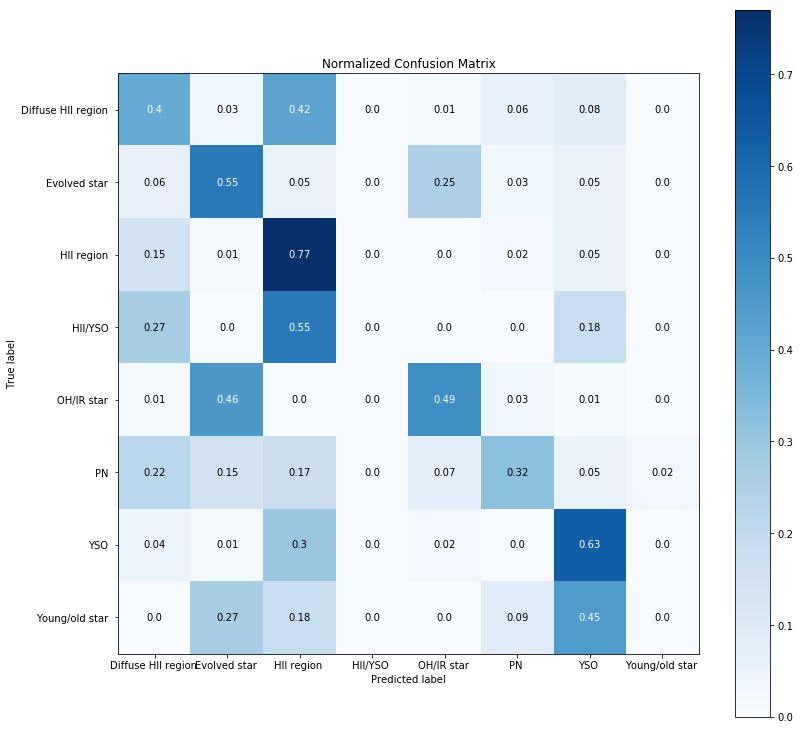

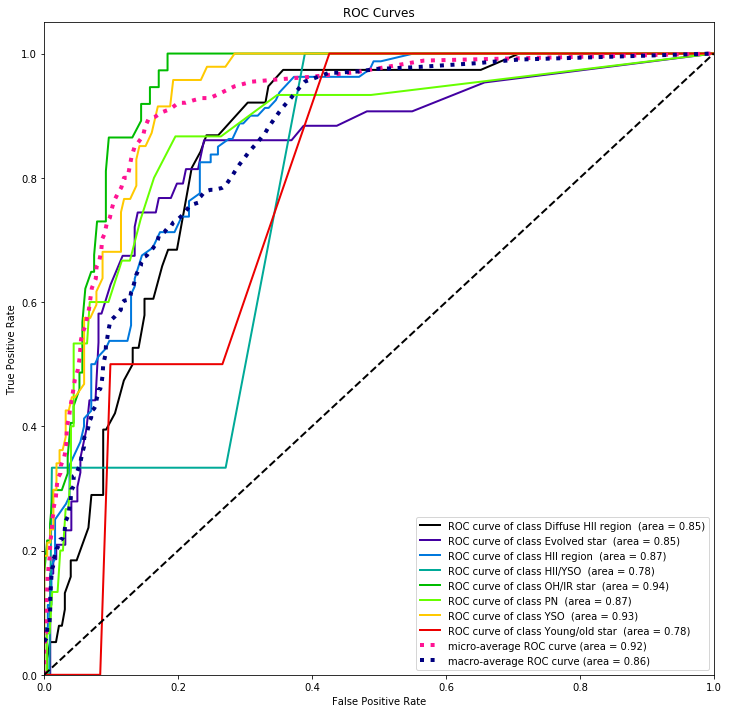

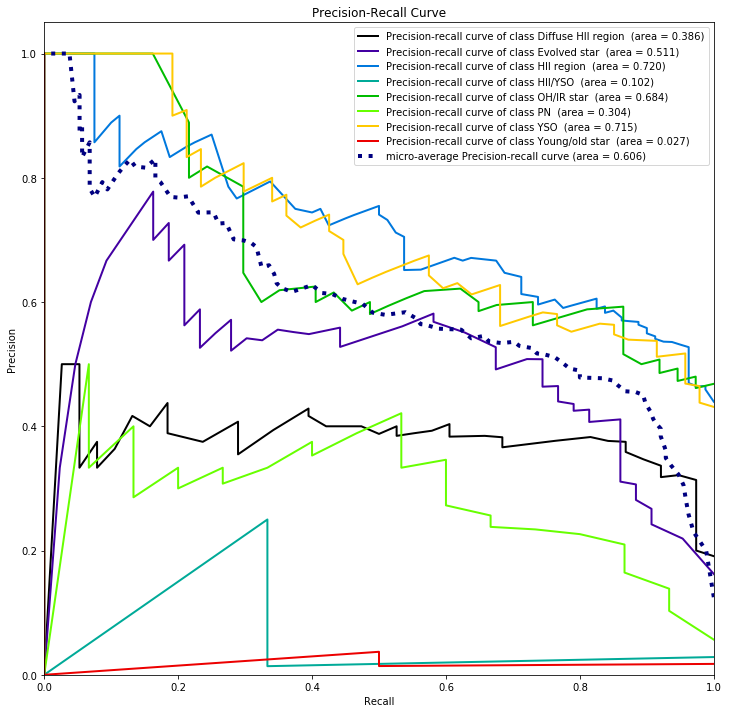

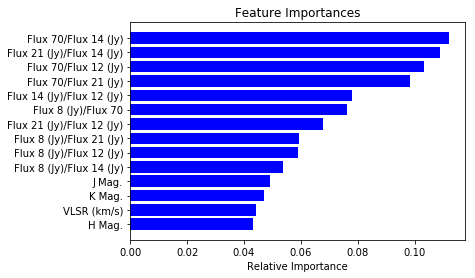

In [70]:
RFC = RandomForestClassifier(n_jobs=20,n_estimators=100, criterion="gini")
RFC.fit(X_train,y_train)
rfc_predict = RFC.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=[np.str(i) for i in np.arange(0,len(np.unique(df['Source Type'])))] ))#=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
predictions = cross_val_predict(RFC, features, targets, cv=10)
#print(rfc_cv_score)
#print('\n')
#print("=== Mean AUC Score ===")
#print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
#rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')
skplt.metrics.plot_confusion_matrix(targets, predictions, normalize=True, figsize=(13,13))
probas = RFC.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas, figsize=(12,12))
skplt.metrics.plot_precision_recall(y_test, probas, figsize=(12,12))
plt.show()
importances = RFC.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feature_names)[indices])
plt.xlabel('Relative Importance')
plt.show()

Notes:

- If ? and ?? classes are left in, the classifier does a decent job of grouping them together
- If the classes are folded together, the classifier does a not-so-great job anymore -> ? and ?? classes might be something else
- If Rejected class is left in, the classifier can also do a good job
- Weighting does not seem to make a difference
- GridSearchCV never worked, however see https://stackoverflow.com/questions/26210471/scikit-learn-gridsearch-giving-valueerror-multiclass-format-is-not-supported/26210645
- Randomizing Herschel flux did not work very well, better to only use data for which 70 micron flux is known
- Can't recall precisely how Flux_70.csv file was obtained, (Herschel query notebook does not seem to do the trick in quite the same manner, e.g. matching and sorting are seemingly done elsewhere). Juan Rendón might know.
- There is a Simbad OTYPE catalog, could be useful for benchmarking this classification.
- Slack: http://rada-dirty-work.slack.com/
    